In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download

In [2]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.2 MB/s eta 0:00:00


## Import libraries

In [3]:
import re
import ast
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam
from torchtext.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pyvi import ViTokenizer

# pre-processing

In [4]:
def normalize(text):
    t = text.replace('\n', ' ')
    t = t.lower()
    return t

def delete_hashtag(text):
    return re.sub(r'#\w+', '', text)

def delete_link(text):
    return re.sub(r'http\S+', '', text)

def remove_emojis(text):
    emoj = re.compile(r"""[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251\U0001f926-\U0001f937\U00010000-\U0010ffff\u200d\u23cf\u23e9\u231a\ufe0f\u3030-]+(?<!\n)""", re.UNICODE)
    return re.sub(emoj, '', text)

def encode_number(text):
    t = text.split(' ')
    t = map(lambda x: '<number>' if bool(re.match(r'^[0-9]+(\.[0-9]+)?$', x)) else x, t)
    return ' '.join(t)

def delete_onelen_token(text):
    t = text.split(' ')
    t = filter(lambda x: len(x)>1, t)
    return ' '.join(t)

def preprocessing(text):
    t = normalize(text)
    t = delete_hashtag(t)
    t = delete_link(t)
    t = remove_emojis(t)
    t = ViTokenizer.tokenize(t)
    t = encode_number(t)
    t = delete_onelen_token(t)
    return t

#Model and Training

In [5]:
%cd /content/drive/MyDrive/CS114

/content/drive/.shortcut-targets-by-id/1Y8ECOyKvn31ywCsUN8dtq1YwMiMpEqep/CS114


## Define class dataset

In [32]:
class HashTag_Dataset(Dataset):
  def __init__(self, root, max_length=250):
    super(HashTag_Dataset, self).__init__()
    self.classes = ['#Q&A', '#cv', '#data', '#deep_learning', '#machine_learning', '#math', '#nlp', '#python', '#sharing']
    text, labels = [], []

    df = pd.read_csv(root, encoding='utf-8-sig')
    texts = df['text']
    labels = df["label"]
    self.texts = texts
    self.labels = labels
    self.vocab = self.make_vocab(texts)
    self.max_length = max_length
  def make_vocab(self, texts):
    vocab = dict()
    for text in texts:
      words = text.split()
      for word in words:
        if word not in vocab:
          vocab[word] = 1
        else:
          vocab[word] += 1
    vocab = list(dict(filter(lambda x: x[1]>3, vocab.items())).keys())
    vocab.append('<UNK>')
    vocab.append('<PAD>')
    return vocab
  def encode_text(self, text):
    words = text.split()
    if len(words) > self.max_length:
      words = words[:self.max_length]
    else:
      words += ['<PAD>']*(self.max_length-len(words))
    enc = [self.vocab.index(w) if w in self.vocab else self.vocab.index('<UNK>') for w in words]
    return enc
  def encode_label(self, label):
    enc = ast.literal_eval(label)
    enc = [1 if l in enc else 0 for l in self.classes]
    return enc
  def __len__(self):
    return len(self.labels)

  def len_vocab(self):
    return len(self.vocab)

  def num_classes(self):
    return len(self.classes)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encode = self.encode_text(text)
    label = self.encode_label(label)
    encode = torch.tensor(encode, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float32)
    return encode, label

## Create the model

In [33]:
class HashtagRecommendation(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_labels):
    super(HashtagRecommendation, self).__init__()
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, num_labels)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, _ = self.lstm(embeds)
    # Select the last output of LSTM layer
    lstm_out = lstm_out[:, -1, :]
    x = self.relu(self.fc1(lstm_out))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    logits = self.fc3(x)
    probs = self.sigmoid(logits)
    return probs

# define metrics

In [34]:
def accuracy(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]
def Recall(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_true[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
  return temp/ y_true.shape[0]
def Precision(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_pred[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
  return temp/ y_true.shape[0]
def F1Measure(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
          continue
      temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
  return temp/ y_true.shape[0]

# Training

In [40]:
train_set = HashTag_Dataset(root = "train_data.csv")
test_set = HashTag_Dataset(root = "test_data.csv")
test_loader = DataLoader(test_set, batch_size=2)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
num_epochs = 300

In [41]:
model = HashtagRecommendation(embedding_dim=100,hidden_dim=256,num_labels=train_set.num_classes(), vocab_size=train_set.len_vocab())
model = model.to(device)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_iters = len(train_loader)

In [42]:
best_acc = 0
trainingEpoch_loss = []
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, colour='green')
    step_loss = []

    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)

        # forward
        outputs = model(texts)
        loss_value = criterion(outputs, labels)  # Find the loss

        # backward
        optimizer.zero_grad() # clear the gradients
        loss_value.backward() # calculate gradients
        optimizer.step() # update weights

        # Calculate loss
        progress_bar.set_description("Epoch {}/{}. Iteration {}/{}. Loss {:.5f}".format(epoch+1, num_epochs, iter+1, num_iters, loss_value.item()))
        step_loss.append(loss_value.item())
    trainingEpoch_loss.append(np.array(step_loss).mean())

    # evaluate
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for iter, (texts, labels) in enumerate(progress_bar):
            texts = texts.to(device)
            labels = labels.to(dtype=torch.float).to(device)
            outputs = np.array(model(texts).tolist())
            y_pred.extend((outputs >= 0.5).astype(np.float32))
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy(y_true, y_pred)

    print(f"Accuracy: {acc}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model, '/content/drive/MyDrive/CS114/best1_model.pth')

Epoch 1/300. Iteration 524/524. Loss 0.27649: 100%|██████████| 524/524 [00:20<00:00, 25.50it/s]


Accuracy: 0.3652989821882946


Epoch 2/300. Iteration 524/524. Loss 0.40806: 100%|██████████| 524/524 [00:20<00:00, 25.86it/s]


Accuracy: 0.3652989821882949


Epoch 3/300. Iteration 524/524. Loss 0.34401: 100%|██████████| 524/524 [00:20<00:00, 25.22it/s]


Accuracy: 0.375954198473282


Epoch 4/300. Iteration 524/524. Loss 0.37269: 100%|██████████| 524/524 [00:20<00:00, 25.03it/s]


Accuracy: 0.377226463104325


Epoch 5/300. Iteration 524/524. Loss 0.39833: 100%|██████████| 524/524 [00:21<00:00, 24.55it/s]


Accuracy: 0.38056615776081376


Epoch 6/300. Iteration 524/524. Loss 0.56317: 100%|██████████| 524/524 [00:20<00:00, 26.04it/s]


Accuracy: 0.37865776081424907


Epoch 7/300. Iteration 524/524. Loss 0.47595: 100%|██████████| 524/524 [00:19<00:00, 26.42it/s]


Accuracy: 0.4999204834605589


Epoch 8/300. Iteration 524/524. Loss 0.24445: 100%|██████████| 524/524 [00:19<00:00, 26.31it/s]


Accuracy: 0.54309796437659


Epoch 9/300. Iteration 524/524. Loss 0.58357: 100%|██████████| 524/524 [00:19<00:00, 26.59it/s]


Accuracy: 0.5752226463104327


Epoch 10/300. Iteration 524/524. Loss 0.30446: 100%|██████████| 524/524 [00:20<00:00, 25.00it/s]


Accuracy: 0.5817430025445298


Epoch 11/300. Iteration 524/524. Loss 0.32891: 100%|██████████| 524/524 [00:21<00:00, 24.85it/s]


Accuracy: 0.5914440203562339


Epoch 12/300. Iteration 524/524. Loss 0.42373: 100%|██████████| 524/524 [00:20<00:00, 25.79it/s]


Accuracy: 0.5952608142493643


Epoch 13/300. Iteration 524/524. Loss 0.28149: 100%|██████████| 524/524 [00:20<00:00, 26.16it/s]


Accuracy: 0.596851145038168


Epoch 14/300. Iteration 524/524. Loss 0.09798: 100%|██████████| 524/524 [00:19<00:00, 26.69it/s]


Accuracy: 0.596533078880407


Epoch 15/300. Iteration 524/524. Loss 0.45651: 100%|██████████| 524/524 [00:19<00:00, 26.93it/s]


Accuracy: 0.5944656488549621


Epoch 16/300. Iteration 524/524. Loss 0.26489: 100%|██████████| 524/524 [00:19<00:00, 26.77it/s]


Accuracy: 0.6001908396946566


Epoch 17/300. Iteration 524/524. Loss 0.52951: 100%|██████████| 524/524 [00:21<00:00, 24.70it/s]


Accuracy: 0.601145038167939


Epoch 18/300. Iteration 524/524. Loss 0.35485: 100%|██████████| 524/524 [00:21<00:00, 24.75it/s]


Accuracy: 0.6009064885496183


Epoch 19/300. Iteration 524/524. Loss 0.38166: 100%|██████████| 524/524 [00:19<00:00, 26.35it/s]


Accuracy: 0.6046437659033084


Epoch 20/300. Iteration 524/524. Loss 0.45542: 100%|██████████| 524/524 [00:19<00:00, 26.57it/s]


Accuracy: 0.6048027989821885


Epoch 21/300. Iteration 524/524. Loss 0.28692: 100%|██████████| 524/524 [00:19<00:00, 26.63it/s]


Accuracy: 0.6060750636132322


Epoch 22/300. Iteration 524/524. Loss 0.27277: 100%|██████████| 524/524 [00:19<00:00, 26.44it/s]


Accuracy: 0.6027353689567433


Epoch 23/300. Iteration 524/524. Loss 0.22162: 100%|██████████| 524/524 [00:21<00:00, 24.76it/s]


Accuracy: 0.6073473282442748


Epoch 24/300. Iteration 524/524. Loss 0.48114: 100%|██████████| 524/524 [00:21<00:00, 24.95it/s]


Accuracy: 0.6087786259541988


Epoch 25/300. Iteration 524/524. Loss 0.29802: 100%|██████████| 524/524 [00:19<00:00, 26.54it/s]


Accuracy: 0.6086195928753185


Epoch 26/300. Iteration 524/524. Loss 0.38950: 100%|██████████| 524/524 [00:19<00:00, 26.26it/s]


Accuracy: 0.6119592875318072


Epoch 27/300. Iteration 524/524. Loss 0.12684: 100%|██████████| 524/524 [00:19<00:00, 26.27it/s]


Accuracy: 0.6106870229007636


Epoch 28/300. Iteration 524/524. Loss 0.27152: 100%|██████████| 524/524 [00:19<00:00, 26.61it/s]


Accuracy: 0.6133905852417306


Epoch 29/300. Iteration 524/524. Loss 0.31872: 100%|██████████| 524/524 [00:20<00:00, 25.36it/s]


Accuracy: 0.6157760814249363


Epoch 30/300. Iteration 524/524. Loss 0.31577: 100%|██████████| 524/524 [00:21<00:00, 24.36it/s]


Accuracy: 0.6132315521628504


Epoch 31/300. Iteration 524/524. Loss 0.63514: 100%|██████████| 524/524 [00:19<00:00, 26.25it/s]


Accuracy: 0.6130725190839696


Epoch 32/300. Iteration 524/524. Loss 0.40672: 100%|██████████| 524/524 [00:20<00:00, 26.09it/s]


Accuracy: 0.614026717557252


Epoch 33/300. Iteration 524/524. Loss 0.27628: 100%|██████████| 524/524 [00:19<00:00, 26.45it/s]


Accuracy: 0.6154580152671759


Epoch 34/300. Iteration 524/524. Loss 0.27042: 100%|██████████| 524/524 [00:20<00:00, 26.00it/s]


Accuracy: 0.6152989821882954


Epoch 35/300. Iteration 524/524. Loss 0.48848: 100%|██████████| 524/524 [00:21<00:00, 24.87it/s]


Accuracy: 0.6172073791348603


Epoch 36/300. Iteration 524/524. Loss 0.31342: 100%|██████████| 524/524 [00:21<00:00, 24.42it/s]


Accuracy: 0.6181615776081425


Epoch 37/300. Iteration 524/524. Loss 0.10883: 100%|██████████| 524/524 [00:19<00:00, 26.51it/s]


Accuracy: 0.6184796437659033


Epoch 38/300. Iteration 524/524. Loss 0.38757: 100%|██████████| 524/524 [00:19<00:00, 26.51it/s]


Accuracy: 0.6197519083969463


Epoch 39/300. Iteration 524/524. Loss 0.21006: 100%|██████████| 524/524 [00:19<00:00, 26.44it/s]


Accuracy: 0.6190362595419847


Epoch 40/300. Iteration 524/524. Loss 0.49733: 100%|██████████| 524/524 [00:19<00:00, 26.51it/s]


Accuracy: 0.6175254452926211


Epoch 41/300. Iteration 524/524. Loss 0.21082: 100%|██████████| 524/524 [00:19<00:00, 26.35it/s]


Accuracy: 0.6175254452926214


Epoch 42/300. Iteration 524/524. Loss 0.14692: 100%|██████████| 524/524 [00:21<00:00, 24.80it/s]


Accuracy: 0.6185591603053435


Epoch 43/300. Iteration 524/524. Loss 0.35580: 100%|██████████| 524/524 [00:21<00:00, 24.83it/s]


Accuracy: 0.6200699745547076


Epoch 44/300. Iteration 524/524. Loss 0.22775: 100%|██████████| 524/524 [00:20<00:00, 25.83it/s]


Accuracy: 0.6157760814249368


Epoch 45/300. Iteration 524/524. Loss 0.30602: 100%|██████████| 524/524 [00:19<00:00, 26.32it/s]


Accuracy: 0.6173664122137409


Epoch 46/300. Iteration 524/524. Loss 0.21157: 100%|██████████| 524/524 [00:19<00:00, 26.75it/s]


Accuracy: 0.6181615776081429


Epoch 47/300. Iteration 524/524. Loss 0.22393: 100%|██████████| 524/524 [00:19<00:00, 26.43it/s]


Accuracy: 0.6207061068702291


Epoch 48/300. Iteration 524/524. Loss 0.32107: 100%|██████████| 524/524 [00:19<00:00, 26.30it/s]


Accuracy: 0.6192748091603052


Epoch 49/300. Iteration 524/524. Loss 0.72155: 100%|██████████| 524/524 [00:21<00:00, 24.44it/s]


Accuracy: 0.6221374045801529


Epoch 50/300. Iteration 524/524. Loss 0.20564: 100%|██████████| 524/524 [00:20<00:00, 25.22it/s]


Accuracy: 0.6187977099236641


Epoch 51/300. Iteration 524/524. Loss 0.14509: 100%|██████████| 524/524 [00:19<00:00, 26.67it/s]


Accuracy: 0.6208651399491099


Epoch 52/300. Iteration 524/524. Loss 0.09192: 100%|██████████| 524/524 [00:19<00:00, 26.39it/s]


Accuracy: 0.6221374045801529


Epoch 53/300. Iteration 524/524. Loss 0.21732: 100%|██████████| 524/524 [00:19<00:00, 26.27it/s]


Accuracy: 0.6251590330788804


Epoch 54/300. Iteration 524/524. Loss 0.28225: 100%|██████████| 524/524 [00:19<00:00, 26.44it/s]


Accuracy: 0.6230916030534354


Epoch 55/300. Iteration 524/524. Loss 0.12045: 100%|██████████| 524/524 [00:20<00:00, 25.02it/s]


Accuracy: 0.6253180661577609


Epoch 56/300. Iteration 524/524. Loss 0.28065: 100%|██████████| 524/524 [00:21<00:00, 24.74it/s]


Accuracy: 0.6241253180661581


Epoch 57/300. Iteration 524/524. Loss 0.31162: 100%|██████████| 524/524 [00:20<00:00, 25.98it/s]


Accuracy: 0.6423505089058522


Epoch 58/300. Iteration 524/524. Loss 0.01612: 100%|██████████| 524/524 [00:20<00:00, 26.17it/s]


Accuracy: 0.6329516539440209


Epoch 59/300. Iteration 524/524. Loss 0.21576: 100%|██████████| 524/524 [00:19<00:00, 26.58it/s]


Accuracy: 0.6524332061068708


Epoch 60/300. Iteration 524/524. Loss 0.34255: 100%|██████████| 524/524 [00:19<00:00, 26.45it/s]


Accuracy: 0.6455947837150132


Epoch 61/300. Iteration 524/524. Loss 0.23840: 100%|██████████| 524/524 [00:19<00:00, 26.31it/s]


Accuracy: 0.6289758269720104


Epoch 62/300. Iteration 524/524. Loss 0.17606: 100%|██████████| 524/524 [00:20<00:00, 24.96it/s]


Accuracy: 0.6510973282442756


Epoch 63/300. Iteration 524/524. Loss 0.16197: 100%|██████████| 524/524 [00:21<00:00, 24.77it/s]


Accuracy: 0.6561863867684481


Epoch 64/300. Iteration 524/524. Loss 0.22703: 100%|██████████| 524/524 [00:20<00:00, 25.52it/s]


Accuracy: 0.6522264631043262


Epoch 65/300. Iteration 524/524. Loss 0.07750: 100%|██████████| 524/524 [00:20<00:00, 25.53it/s]


Accuracy: 0.6517970737913489


Epoch 66/300. Iteration 524/524. Loss 0.16795: 100%|██████████| 524/524 [00:20<00:00, 25.74it/s]


Accuracy: 0.6660305343511456


Epoch 67/300. Iteration 524/524. Loss 0.11393: 100%|██████████| 524/524 [00:19<00:00, 26.29it/s]


Accuracy: 0.6744592875318064


Epoch 68/300. Iteration 524/524. Loss 0.09371: 100%|██████████| 524/524 [00:21<00:00, 24.07it/s]


Accuracy: 0.6794688295165399


Epoch 69/300. Iteration 524/524. Loss 0.41173: 100%|██████████| 524/524 [00:21<00:00, 24.55it/s]


Accuracy: 0.6575222646310437


Epoch 70/300. Iteration 524/524. Loss 0.11205: 100%|██████████| 524/524 [00:20<00:00, 25.98it/s]


Accuracy: 0.6625318066157769


Epoch 71/300. Iteration 524/524. Loss 0.15559: 100%|██████████| 524/524 [00:20<00:00, 26.15it/s]


Accuracy: 0.6712786259541987


Epoch 72/300. Iteration 524/524. Loss 0.27216: 100%|██████████| 524/524 [00:19<00:00, 26.44it/s]


Accuracy: 0.6587945292620867


Epoch 73/300. Iteration 524/524. Loss 0.16593: 100%|██████████| 524/524 [00:19<00:00, 26.31it/s]


Accuracy: 0.6778784987277359


Epoch 74/300. Iteration 524/524. Loss 0.12722: 100%|██████████| 524/524 [00:21<00:00, 24.44it/s]


Accuracy: 0.6626908396946574


Epoch 75/300. Iteration 524/524. Loss 0.36400: 100%|██████████| 524/524 [00:21<00:00, 24.14it/s]


Accuracy: 0.6683365139949112


Epoch 76/300. Iteration 524/524. Loss 0.26212: 100%|██████████| 524/524 [00:20<00:00, 25.79it/s]


Accuracy: 0.6822837150127229


Epoch 77/300. Iteration 524/524. Loss 0.12285: 100%|██████████| 524/524 [00:20<00:00, 25.87it/s]


Accuracy: 0.693543256997456


Epoch 78/300. Iteration 524/524. Loss 0.07629: 100%|██████████| 524/524 [00:19<00:00, 26.27it/s]


Accuracy: 0.7054707379134867


Epoch 79/300. Iteration 524/524. Loss 0.15165: 100%|██████████| 524/524 [00:19<00:00, 26.33it/s]


Accuracy: 0.7045165394402031


Epoch 80/300. Iteration 524/524. Loss 0.41660: 100%|██████████| 524/524 [00:21<00:00, 24.94it/s]


Accuracy: 0.6940203562340969


Epoch 81/300. Iteration 524/524. Loss 0.19651: 100%|██████████| 524/524 [00:21<00:00, 24.25it/s]


Accuracy: 0.7204993638676845


Epoch 82/300. Iteration 524/524. Loss 0.16030: 100%|██████████| 524/524 [00:20<00:00, 25.29it/s]


Accuracy: 0.7045960559796436


Epoch 83/300. Iteration 524/524. Loss 0.22075: 100%|██████████| 524/524 [00:20<00:00, 26.06it/s]


Accuracy: 0.7239980916030533


Epoch 84/300. Iteration 524/524. Loss 0.24026: 100%|██████████| 524/524 [00:20<00:00, 25.76it/s]


Accuracy: 0.7098441475826974


Epoch 85/300. Iteration 524/524. Loss 0.13305: 100%|██████████| 524/524 [00:20<00:00, 25.95it/s]


Accuracy: 0.7014949109414768


Epoch 86/300. Iteration 524/524. Loss 0.09179: 100%|██████████| 524/524 [00:20<00:00, 25.73it/s]


Accuracy: 0.70316475826972


Epoch 87/300. Iteration 524/524. Loss 0.09960: 100%|██████████| 524/524 [00:22<00:00, 23.63it/s]


Accuracy: 0.7238390585241731


Epoch 88/300. Iteration 524/524. Loss 0.17723: 100%|██████████| 524/524 [00:20<00:00, 25.02it/s]


Accuracy: 0.7229643765903312


Epoch 89/300. Iteration 524/524. Loss 0.30002: 100%|██████████| 524/524 [00:20<00:00, 25.96it/s]


Accuracy: 0.7410941475826973


Epoch 90/300. Iteration 524/524. Loss 0.08809: 100%|██████████| 524/524 [00:20<00:00, 26.16it/s]


Accuracy: 0.7360050890585241


Epoch 91/300. Iteration 524/524. Loss 0.21610: 100%|██████████| 524/524 [00:20<00:00, 26.09it/s]


Accuracy: 0.7453880407124679


Epoch 92/300. Iteration 524/524. Loss 0.22252: 100%|██████████| 524/524 [00:20<00:00, 26.09it/s]


Accuracy: 0.7216125954198481


Epoch 93/300. Iteration 524/524. Loss 0.24184: 100%|██████████| 524/524 [00:21<00:00, 23.89it/s]


Accuracy: 0.7295642493638674


Epoch 94/300. Iteration 524/524. Loss 0.05508: 100%|██████████| 524/524 [00:21<00:00, 24.57it/s]


Accuracy: 0.7499204834605598


Epoch 95/300. Iteration 524/524. Loss 0.06817: 100%|██████████| 524/524 [00:20<00:00, 26.16it/s]


Accuracy: 0.7441952926208659


Epoch 96/300. Iteration 524/524. Loss 0.30951: 100%|██████████| 524/524 [00:20<00:00, 26.04it/s]


Accuracy: 0.7478530534351147


Epoch 97/300. Iteration 524/524. Loss 0.12015: 100%|██████████| 524/524 [00:20<00:00, 26.04it/s]


Accuracy: 0.7653466921119592


Epoch 98/300. Iteration 524/524. Loss 0.14081: 100%|██████████| 524/524 [00:20<00:00, 25.94it/s]


Accuracy: 0.7597805343511455


Epoch 99/300. Iteration 524/524. Loss 0.16229: 100%|██████████| 524/524 [00:21<00:00, 24.33it/s]


Accuracy: 0.7402830788804068


Epoch 100/300. Iteration 524/524. Loss 0.10439: 100%|██████████| 524/524 [00:21<00:00, 24.40it/s]


Accuracy: 0.7567589058524167


Epoch 101/300. Iteration 524/524. Loss 0.14083: 100%|██████████| 524/524 [00:20<00:00, 25.99it/s]


Accuracy: 0.7464217557251918


Epoch 102/300. Iteration 524/524. Loss 0.00711: 100%|██████████| 524/524 [00:19<00:00, 26.41it/s]


Accuracy: 0.7645515267175571


Epoch 103/300. Iteration 524/524. Loss 0.36945: 100%|██████████| 524/524 [00:20<00:00, 26.01it/s]


Accuracy: 0.7512722646310441


Epoch 104/300. Iteration 524/524. Loss 0.10121: 100%|██████████| 524/524 [00:20<00:00, 26.17it/s]


Accuracy: 0.781965648854961


Epoch 105/300. Iteration 524/524. Loss 0.63250: 100%|██████████| 524/524 [00:20<00:00, 25.40it/s]


Accuracy: 0.7694020356234095


Epoch 106/300. Iteration 524/524. Loss 0.02765: 100%|██████████| 524/524 [00:21<00:00, 24.09it/s]


Accuracy: 0.7768765903307887


Epoch 107/300. Iteration 524/524. Loss 0.15943: 100%|██████████| 524/524 [00:21<00:00, 24.54it/s]


Accuracy: 0.7838740458015265


Epoch 108/300. Iteration 524/524. Loss 0.05100: 100%|██████████| 524/524 [00:20<00:00, 26.00it/s]


Accuracy: 0.768368320610687


Epoch 109/300. Iteration 524/524. Loss 0.05025: 100%|██████████| 524/524 [00:20<00:00, 25.95it/s]


Accuracy: 0.7909510178117043


Epoch 110/300. Iteration 524/524. Loss 0.02276: 100%|██████████| 524/524 [00:20<00:00, 25.93it/s]


Accuracy: 0.7893606870229


Epoch 111/300. Iteration 524/524. Loss 0.29240: 100%|██████████| 524/524 [00:20<00:00, 26.00it/s]


Accuracy: 0.78668893129771


Epoch 112/300. Iteration 524/524. Loss 0.14380: 100%|██████████| 524/524 [00:21<00:00, 24.69it/s]


Accuracy: 0.788167938931297


Epoch 113/300. Iteration 524/524. Loss 0.58763: 100%|██████████| 524/524 [00:21<00:00, 24.28it/s]


Accuracy: 0.7954039440203569


Epoch 114/300. Iteration 524/524. Loss 0.07951: 100%|██████████| 524/524 [00:20<00:00, 26.00it/s]


Accuracy: 0.8009701017811707


Epoch 115/300. Iteration 524/524. Loss 0.12292: 100%|██████████| 524/524 [00:19<00:00, 26.25it/s]


Accuracy: 0.8022423664122136


Epoch 116/300. Iteration 524/524. Loss 0.11896: 100%|██████████| 524/524 [00:19<00:00, 26.47it/s]


Accuracy: 0.8075699745547074


Epoch 117/300. Iteration 524/524. Loss 0.12633: 100%|██████████| 524/524 [00:19<00:00, 26.36it/s]


Accuracy: 0.8254930025445291


Epoch 118/300. Iteration 524/524. Loss 0.33384: 100%|██████████| 524/524 [00:19<00:00, 26.22it/s]


Accuracy: 0.8274013994910934


Epoch 119/300. Iteration 524/524. Loss 0.05745: 100%|██████████| 524/524 [00:20<00:00, 25.33it/s]


Accuracy: 0.8302321882951655


Epoch 120/300. Iteration 524/524. Loss 0.02321: 100%|██████████| 524/524 [00:21<00:00, 23.92it/s]


Accuracy: 0.8395356234096695


Epoch 121/300. Iteration 524/524. Loss 0.00037: 100%|██████████| 524/524 [00:20<00:00, 25.21it/s]


Accuracy: 0.8379770992366411


Epoch 122/300. Iteration 524/524. Loss 0.21804: 100%|██████████| 524/524 [00:19<00:00, 26.33it/s]


Accuracy: 0.8486323155216282


Epoch 123/300. Iteration 524/524. Loss 0.22082: 100%|██████████| 524/524 [00:19<00:00, 26.20it/s]


Accuracy: 0.8221215012722651


Epoch 124/300. Iteration 524/524. Loss 0.36005: 100%|██████████| 524/524 [00:19<00:00, 26.26it/s]


Accuracy: 0.8241094147582697


Epoch 125/300. Iteration 524/524. Loss 0.16198: 100%|██████████| 524/524 [00:19<00:00, 26.47it/s]


Accuracy: 0.8312659033078886


Epoch 126/300. Iteration 524/524. Loss 0.00134: 100%|██████████| 524/524 [00:20<00:00, 25.62it/s]


Accuracy: 0.8456424936386769


Epoch 127/300. Iteration 524/524. Loss 0.15466: 100%|██████████| 524/524 [00:21<00:00, 24.50it/s]


Accuracy: 0.835639312977099


Epoch 128/300. Iteration 524/524. Loss 0.03307: 100%|██████████| 524/524 [00:21<00:00, 24.66it/s]


Accuracy: 0.8352735368956754


Epoch 129/300. Iteration 524/524. Loss 0.05538: 100%|██████████| 524/524 [00:20<00:00, 25.74it/s]


Accuracy: 0.8493161577608145


Epoch 130/300. Iteration 524/524. Loss 0.09021: 100%|██████████| 524/524 [00:19<00:00, 26.27it/s]


Accuracy: 0.8508269720101774


Epoch 131/300. Iteration 524/524. Loss 0.02832: 100%|██████████| 524/524 [00:20<00:00, 26.13it/s]


Accuracy: 0.8645038167938929


Epoch 132/300. Iteration 524/524. Loss 0.39318: 100%|██████████| 524/524 [00:20<00:00, 25.99it/s]


Accuracy: 0.8229484732824424


Epoch 133/300. Iteration 524/524. Loss 0.12301: 100%|██████████| 524/524 [00:20<00:00, 26.11it/s]


Accuracy: 0.8509860050890589


Epoch 134/300. Iteration 524/524. Loss 0.02737: 100%|██████████| 524/524 [00:21<00:00, 24.21it/s]


Accuracy: 0.8427162849872772


Epoch 135/300. Iteration 524/524. Loss 0.28215: 100%|██████████| 524/524 [00:21<00:00, 24.37it/s]


Accuracy: 0.8708651399491096


Epoch 136/300. Iteration 524/524. Loss 0.01849: 100%|██████████| 524/524 [00:20<00:00, 25.93it/s]


Accuracy: 0.8641062340966925


Epoch 137/300. Iteration 524/524. Loss 0.14982: 100%|██████████| 524/524 [00:20<00:00, 26.11it/s]


Accuracy: 0.8786100508905852


Epoch 138/300. Iteration 524/524. Loss 0.02153: 100%|██████████| 524/524 [00:19<00:00, 26.25it/s]


Accuracy: 0.8901081424936383


Epoch 139/300. Iteration 524/524. Loss 0.00009: 100%|██████████| 524/524 [00:19<00:00, 26.21it/s]


Accuracy: 0.9009860050890579


Epoch 140/300. Iteration 524/524. Loss 0.19152: 100%|██████████| 524/524 [00:20<00:00, 25.32it/s]


Accuracy: 0.895499363867684


Epoch 141/300. Iteration 524/524. Loss 0.00217: 100%|██████████| 524/524 [00:21<00:00, 23.88it/s]


Accuracy: 0.8992366412213738


Epoch 142/300. Iteration 524/524. Loss 0.33524: 100%|██████████| 524/524 [00:21<00:00, 24.92it/s]


Accuracy: 0.8929548346055975


Epoch 143/300. Iteration 524/524. Loss 0.08599: 100%|██████████| 524/524 [00:20<00:00, 26.08it/s]


Accuracy: 0.9045324427480909


Epoch 144/300. Iteration 524/524. Loss 0.05394: 100%|██████████| 524/524 [00:20<00:00, 25.98it/s]


Accuracy: 0.9050890585241721


Epoch 145/300. Iteration 524/524. Loss 0.02253: 100%|██████████| 524/524 [00:20<00:00, 26.13it/s]


Accuracy: 0.9075858778625947


Epoch 146/300. Iteration 524/524. Loss 0.31667: 100%|██████████| 524/524 [00:20<00:00, 26.06it/s]


Accuracy: 0.8998409669211194


Epoch 147/300. Iteration 524/524. Loss 0.02390: 100%|██████████| 524/524 [00:20<00:00, 25.08it/s]


Accuracy: 0.9094942748091596


Epoch 148/300. Iteration 524/524. Loss 0.31252: 100%|██████████| 524/524 [00:22<00:00, 23.69it/s]


Accuracy: 0.9179707379134853


Epoch 149/300. Iteration 524/524. Loss 0.00762: 100%|██████████| 524/524 [00:21<00:00, 24.82it/s]


Accuracy: 0.9212627226463103


Epoch 150/300. Iteration 524/524. Loss 0.01638: 100%|██████████| 524/524 [00:20<00:00, 26.11it/s]


Accuracy: 0.9089694656488546


Epoch 151/300. Iteration 524/524. Loss 0.34457: 100%|██████████| 524/524 [00:20<00:00, 26.07it/s]


Accuracy: 0.9231393129770986


Epoch 152/300. Iteration 524/524. Loss 0.00325: 100%|██████████| 524/524 [00:20<00:00, 26.01it/s]


Accuracy: 0.9262722646310425


Epoch 153/300. Iteration 524/524. Loss 0.01365: 100%|██████████| 524/524 [00:20<00:00, 25.72it/s]


Accuracy: 0.9018924936386771


Epoch 154/300. Iteration 524/524. Loss 0.00208: 100%|██████████| 524/524 [00:21<00:00, 24.24it/s]


Accuracy: 0.920276717557251


Epoch 155/300. Iteration 524/524. Loss 0.05437: 100%|██████████| 524/524 [00:21<00:00, 24.36it/s]


Accuracy: 0.9266380407124678


Epoch 156/300. Iteration 524/524. Loss 0.23990: 100%|██████████| 524/524 [00:20<00:00, 24.99it/s]


Accuracy: 0.9236959287531799


Epoch 157/300. Iteration 524/524. Loss 0.01636: 100%|██████████| 524/524 [00:20<00:00, 25.90it/s]


Accuracy: 0.9277830788804066


Epoch 158/300. Iteration 524/524. Loss 0.00044: 100%|██████████| 524/524 [00:20<00:00, 25.87it/s]


Accuracy: 0.9187181933842236


Epoch 159/300. Iteration 524/524. Loss 0.04693: 100%|██████████| 524/524 [00:20<00:00, 25.91it/s]


Accuracy: 0.9267970737913483


Epoch 160/300. Iteration 524/524. Loss 0.05226: 100%|██████████| 524/524 [00:20<00:00, 25.85it/s]


Accuracy: 0.9340330788804065


Epoch 161/300. Iteration 524/524. Loss 0.00676: 100%|██████████| 524/524 [00:21<00:00, 24.38it/s]


Accuracy: 0.9229802798982185


Epoch 162/300. Iteration 524/524. Loss 0.22026: 100%|██████████| 524/524 [00:21<00:00, 24.33it/s]


Accuracy: 0.9076335877862594


Epoch 163/300. Iteration 524/524. Loss 0.04427: 100%|██████████| 524/524 [00:21<00:00, 24.71it/s]


Accuracy: 0.9306138676844775


Epoch 164/300. Iteration 524/524. Loss 0.00493: 100%|██████████| 524/524 [00:20<00:00, 25.88it/s]


Accuracy: 0.9398377862595414


Epoch 165/300. Iteration 524/524. Loss 0.25492: 100%|██████████| 524/524 [00:20<00:00, 25.85it/s]


Accuracy: 0.9438772264631037


Epoch 166/300. Iteration 524/524. Loss 0.05716: 100%|██████████| 524/524 [00:20<00:00, 25.99it/s]


Accuracy: 0.9421437659033073


Epoch 167/300. Iteration 524/524. Loss 0.02740: 100%|██████████| 524/524 [00:20<00:00, 25.82it/s]


Accuracy: 0.9391062340966915


Epoch 168/300. Iteration 524/524. Loss 0.03543: 100%|██████████| 524/524 [00:21<00:00, 24.86it/s]


Accuracy: 0.9442430025445285


Epoch 169/300. Iteration 524/524. Loss 0.06942: 100%|██████████| 524/524 [00:21<00:00, 24.06it/s]


Accuracy: 0.941284987277353


Epoch 170/300. Iteration 524/524. Loss 0.01658: 100%|██████████| 524/524 [00:21<00:00, 24.66it/s]


Accuracy: 0.9362436386768437


Epoch 171/300. Iteration 524/524. Loss 0.02629: 100%|██████████| 524/524 [00:20<00:00, 26.08it/s]


Accuracy: 0.9335559796437654


Epoch 172/300. Iteration 524/524. Loss 0.02124: 100%|██████████| 524/524 [00:20<00:00, 25.89it/s]


Accuracy: 0.9346692111959283


Epoch 173/300. Iteration 524/524. Loss 0.19107: 100%|██████████| 524/524 [00:20<00:00, 25.95it/s]


Accuracy: 0.9413804071246812


Epoch 174/300. Iteration 524/524. Loss 0.01494: 100%|██████████| 524/524 [00:20<00:00, 26.12it/s]


Accuracy: 0.9448950381679384


Epoch 175/300. Iteration 524/524. Loss 0.09308: 100%|██████████| 524/524 [00:21<00:00, 24.93it/s]


Accuracy: 0.9415076335877854


Epoch 176/300. Iteration 524/524. Loss 0.00314: 100%|██████████| 524/524 [00:22<00:00, 23.59it/s]


Accuracy: 0.9431297709923656


Epoch 177/300. Iteration 524/524. Loss 0.12186: 100%|██████████| 524/524 [00:21<00:00, 24.78it/s]


Accuracy: 0.9055502544529256


Epoch 178/300. Iteration 524/524. Loss 0.03418: 100%|██████████| 524/524 [00:20<00:00, 26.13it/s]


Accuracy: 0.9446723918575055


Epoch 179/300. Iteration 524/524. Loss 0.10128: 100%|██████████| 524/524 [00:20<00:00, 25.98it/s]


Accuracy: 0.9346692111959283


Epoch 180/300. Iteration 524/524. Loss 0.00091: 100%|██████████| 524/524 [00:20<00:00, 25.81it/s]


Accuracy: 0.9480279898218826


Epoch 181/300. Iteration 524/524. Loss 0.37034: 100%|██████████| 524/524 [00:20<00:00, 25.50it/s]


Accuracy: 0.9477894402035615


Epoch 182/300. Iteration 524/524. Loss 0.18679: 100%|██████████| 524/524 [00:21<00:00, 24.65it/s]


Accuracy: 0.948107506361322


Epoch 183/300. Iteration 524/524. Loss 0.01161: 100%|██████████| 524/524 [00:21<00:00, 24.01it/s]


Accuracy: 0.9482665394402029


Epoch 184/300. Iteration 524/524. Loss 0.01243: 100%|██████████| 524/524 [00:21<00:00, 24.47it/s]


Accuracy: 0.9387086513994906


Epoch 185/300. Iteration 524/524. Loss 0.00124: 100%|██████████| 524/524 [00:20<00:00, 25.33it/s]


Accuracy: 0.9454039440203558


Epoch 186/300. Iteration 524/524. Loss 0.00013: 100%|██████████| 524/524 [00:20<00:00, 25.63it/s]


Accuracy: 0.9431774809160303


Epoch 187/300. Iteration 524/524. Loss 0.04825: 100%|██████████| 524/524 [00:20<00:00, 25.68it/s]


Accuracy: 0.9425731552162847


Epoch 188/300. Iteration 524/524. Loss 0.26102: 100%|██████████| 524/524 [00:20<00:00, 25.52it/s]


Accuracy: 0.9456424936386765


Epoch 189/300. Iteration 524/524. Loss 0.00670: 100%|██████████| 524/524 [00:21<00:00, 24.71it/s]


Accuracy: 0.9460082697201014


Epoch 190/300. Iteration 524/524. Loss 0.00005: 100%|██████████| 524/524 [00:21<00:00, 24.34it/s]


Accuracy: 0.9487913486005085


Epoch 191/300. Iteration 524/524. Loss 0.00521: 100%|██████████| 524/524 [00:21<00:00, 24.31it/s]


Accuracy: 0.9429389312977093


Epoch 192/300. Iteration 524/524. Loss 0.00012: 100%|██████████| 524/524 [00:20<00:00, 25.24it/s]


Accuracy: 0.9472010178117044


Epoch 193/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:20<00:00, 25.68it/s]


Accuracy: 0.9432092875318062


Epoch 194/300. Iteration 524/524. Loss 0.00068: 100%|██████████| 524/524 [00:20<00:00, 25.73it/s]


Accuracy: 0.9447996183206102


Epoch 195/300. Iteration 524/524. Loss 0.33730: 100%|██████████| 524/524 [00:20<00:00, 25.57it/s]


Accuracy: 0.9457220101781167


Epoch 196/300. Iteration 524/524. Loss 0.00279: 100%|██████████| 524/524 [00:20<00:00, 25.64it/s]


Accuracy: 0.9367843511450379


Epoch 197/300. Iteration 524/524. Loss 0.17385: 100%|██████████| 524/524 [00:21<00:00, 24.79it/s]


Accuracy: 0.9398854961832053


Epoch 198/300. Iteration 524/524. Loss 0.02895: 100%|██████████| 524/524 [00:21<00:00, 23.85it/s]


Accuracy: 0.9488549618320605


Epoch 199/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:21<00:00, 24.47it/s]


Accuracy: 0.9519402035623403


Epoch 200/300. Iteration 524/524. Loss 0.00227: 100%|██████████| 524/524 [00:20<00:00, 25.57it/s]


Accuracy: 0.955263994910941


Epoch 201/300. Iteration 524/524. Loss 0.09984: 100%|██████████| 524/524 [00:20<00:00, 25.49it/s]


Accuracy: 0.954516539440203


Epoch 202/300. Iteration 524/524. Loss 0.00056: 100%|██████████| 524/524 [00:20<00:00, 25.58it/s]


Accuracy: 0.9383905852417299


Epoch 203/300. Iteration 524/524. Loss 0.04322: 100%|██████████| 524/524 [00:20<00:00, 25.76it/s]


Accuracy: 0.9513199745547073


Epoch 204/300. Iteration 524/524. Loss 0.04812: 100%|██████████| 524/524 [00:21<00:00, 24.34it/s]


Accuracy: 0.9263358778625947


Epoch 205/300. Iteration 524/524. Loss 0.00313: 100%|██████████| 524/524 [00:22<00:00, 23.21it/s]


Accuracy: 0.9495069974554701


Epoch 206/300. Iteration 524/524. Loss 0.02312: 100%|██████████| 524/524 [00:21<00:00, 24.38it/s]


Accuracy: 0.9365458015267167


Epoch 207/300. Iteration 524/524. Loss 0.00006: 100%|██████████| 524/524 [00:20<00:00, 25.67it/s]


Accuracy: 0.9442748091603046


Epoch 208/300. Iteration 524/524. Loss 0.13489: 100%|██████████| 524/524 [00:20<00:00, 25.59it/s]


Accuracy: 0.9510814249363863


Epoch 209/300. Iteration 524/524. Loss 0.00110: 100%|██████████| 524/524 [00:20<00:00, 25.53it/s]


Accuracy: 0.9590330788804066


Epoch 210/300. Iteration 524/524. Loss 0.00114: 100%|██████████| 524/524 [00:20<00:00, 25.23it/s]


Accuracy: 0.9556297709923657


Epoch 211/300. Iteration 524/524. Loss 0.01330: 100%|██████████| 524/524 [00:22<00:00, 23.65it/s]


Accuracy: 0.9528784987277346


Epoch 212/300. Iteration 524/524. Loss 0.07007: 100%|██████████| 524/524 [00:21<00:00, 23.95it/s]


Accuracy: 0.9535146310432568


Epoch 213/300. Iteration 524/524. Loss 0.00463: 100%|██████████| 524/524 [00:20<00:00, 25.15it/s]


Accuracy: 0.9518129770992358


Epoch 214/300. Iteration 524/524. Loss 0.01297: 100%|██████████| 524/524 [00:20<00:00, 25.52it/s]


Accuracy: 0.947837150127226


Epoch 215/300. Iteration 524/524. Loss 0.00001: 100%|██████████| 524/524 [00:20<00:00, 25.61it/s]


Accuracy: 0.9517811704834598


Epoch 216/300. Iteration 524/524. Loss 0.05304: 100%|██████████| 524/524 [00:20<00:00, 25.23it/s]


Accuracy: 0.9576335877862592


Epoch 217/300. Iteration 524/524. Loss 0.00464: 100%|██████████| 524/524 [00:22<00:00, 23.66it/s]


Accuracy: 0.9551526717557246


Epoch 218/300. Iteration 524/524. Loss 0.03416: 100%|██████████| 524/524 [00:22<00:00, 23.74it/s]


Accuracy: 0.928848600508905


Epoch 219/300. Iteration 524/524. Loss 0.06737: 100%|██████████| 524/524 [00:21<00:00, 24.74it/s]


Accuracy: 0.9542779898218824


Epoch 220/300. Iteration 524/524. Loss 0.00046: 100%|██████████| 524/524 [00:20<00:00, 25.32it/s]


Accuracy: 0.9554548346055971


Epoch 221/300. Iteration 524/524. Loss 0.02523: 100%|██████████| 524/524 [00:20<00:00, 25.43it/s]


Accuracy: 0.9582856234096683


Epoch 222/300. Iteration 524/524. Loss 0.00015: 100%|██████████| 524/524 [00:20<00:00, 25.14it/s]


Accuracy: 0.9554866412213735


Epoch 223/300. Iteration 524/524. Loss 0.01146: 100%|██████████| 524/524 [00:21<00:00, 24.87it/s]


Accuracy: 0.9521469465648846


Epoch 224/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:21<00:00, 23.86it/s]


Accuracy: 0.9554707379134854


Epoch 225/300. Iteration 524/524. Loss 0.00771: 100%|██████████| 524/524 [00:22<00:00, 23.76it/s]


Accuracy: 0.9561863867684475


Epoch 226/300. Iteration 524/524. Loss 0.01673: 100%|██████████| 524/524 [00:21<00:00, 24.66it/s]


Accuracy: 0.9575699745547068


Epoch 227/300. Iteration 524/524. Loss 0.07908: 100%|██████████| 524/524 [00:20<00:00, 25.65it/s]


Accuracy: 0.9493638676844778


Epoch 228/300. Iteration 524/524. Loss 0.06628: 100%|██████████| 524/524 [00:20<00:00, 25.36it/s]


Accuracy: 0.9532283715012715


Epoch 229/300. Iteration 524/524. Loss 0.00056: 100%|██████████| 524/524 [00:20<00:00, 25.45it/s]


Accuracy: 0.9437181933842238


Epoch 230/300. Iteration 524/524. Loss 0.00029: 100%|██████████| 524/524 [00:20<00:00, 25.06it/s]


Accuracy: 0.9573155216284979


Epoch 231/300. Iteration 524/524. Loss 0.01293: 100%|██████████| 524/524 [00:21<00:00, 23.89it/s]


Accuracy: 0.9573791348600503


Epoch 232/300. Iteration 524/524. Loss 0.00529: 100%|██████████| 524/524 [00:22<00:00, 23.79it/s]


Accuracy: 0.9582538167938927


Epoch 233/300. Iteration 524/524. Loss 0.03104: 100%|██████████| 524/524 [00:21<00:00, 24.60it/s]


Accuracy: 0.95640903307888


Epoch 234/300. Iteration 524/524. Loss 0.01691: 100%|██████████| 524/524 [00:20<00:00, 25.36it/s]


Accuracy: 0.955391221374045


Epoch 235/300. Iteration 524/524. Loss 0.00184: 100%|██████████| 524/524 [00:20<00:00, 24.99it/s]


Accuracy: 0.9349077608142485


Epoch 236/300. Iteration 524/524. Loss 0.13528: 100%|██████████| 524/524 [00:20<00:00, 25.11it/s]


Accuracy: 0.9515267175572517


Epoch 237/300. Iteration 524/524. Loss 0.00005: 100%|██████████| 524/524 [00:21<00:00, 24.31it/s]


Accuracy: 0.9404421119592868


Epoch 238/300. Iteration 524/524. Loss 0.02932: 100%|██████████| 524/524 [00:22<00:00, 23.49it/s]


Accuracy: 0.9604325699745544


Epoch 239/300. Iteration 524/524. Loss 0.00242: 100%|██████████| 524/524 [00:21<00:00, 24.30it/s]


Accuracy: 0.9576176844783709


Epoch 240/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:20<00:00, 25.52it/s]


Accuracy: 0.9586832061068694


Epoch 241/300. Iteration 524/524. Loss 0.10306: 100%|██████████| 524/524 [00:20<00:00, 25.10it/s]


Accuracy: 0.9615298982188291


Epoch 242/300. Iteration 524/524. Loss 0.00245: 100%|██████████| 524/524 [00:20<00:00, 25.06it/s]


Accuracy: 0.9517652671755719


Epoch 243/300. Iteration 524/524. Loss 0.08766: 100%|██████████| 524/524 [00:21<00:00, 24.86it/s]


Accuracy: 0.9549459287531801


Epoch 244/300. Iteration 524/524. Loss 0.09988: 100%|██████████| 524/524 [00:22<00:00, 23.41it/s]


Accuracy: 0.960003180661577


Epoch 245/300. Iteration 524/524. Loss 0.14634: 100%|██████████| 524/524 [00:22<00:00, 23.71it/s]


Accuracy: 0.9571405852417302


Epoch 246/300. Iteration 524/524. Loss 0.03815: 100%|██████████| 524/524 [00:20<00:00, 24.96it/s]


Accuracy: 0.9575381679389305


Epoch 247/300. Iteration 524/524. Loss 0.02761: 100%|██████████| 524/524 [00:20<00:00, 25.39it/s]


Accuracy: 0.9549777353689564


Epoch 248/300. Iteration 524/524. Loss 0.01467: 100%|██████████| 524/524 [00:20<00:00, 25.25it/s]


Accuracy: 0.9534351145038163


Epoch 249/300. Iteration 524/524. Loss 0.01559: 100%|██████████| 524/524 [00:20<00:00, 25.31it/s]


Accuracy: 0.9557410941475815


Epoch 250/300. Iteration 524/524. Loss 0.00965: 100%|██████████| 524/524 [00:21<00:00, 24.78it/s]


Accuracy: 0.9574904580152663


Epoch 251/300. Iteration 524/524. Loss 0.00726: 100%|██████████| 524/524 [00:22<00:00, 23.24it/s]


Accuracy: 0.9623091603053427


Epoch 252/300. Iteration 524/524. Loss 0.12816: 100%|██████████| 524/524 [00:22<00:00, 23.76it/s]


Accuracy: 0.9610368956742998


Epoch 253/300. Iteration 524/524. Loss 0.00216: 100%|██████████| 524/524 [00:20<00:00, 25.09it/s]


Accuracy: 0.9691475826972005


Epoch 254/300. Iteration 524/524. Loss 0.00057: 100%|██████████| 524/524 [00:20<00:00, 25.30it/s]


Accuracy: 0.9644561068702283


Epoch 255/300. Iteration 524/524. Loss 0.01138: 100%|██████████| 524/524 [00:20<00:00, 25.08it/s]


Accuracy: 0.9570292620865133


Epoch 256/300. Iteration 524/524. Loss 0.01165: 100%|██████████| 524/524 [00:20<00:00, 25.14it/s]


Accuracy: 0.9585718829516531


Epoch 257/300. Iteration 524/524. Loss 0.04614: 100%|██████████| 524/524 [00:22<00:00, 23.59it/s]


Accuracy: 0.9618161577608136


Epoch 258/300. Iteration 524/524. Loss 0.00021: 100%|██████████| 524/524 [00:22<00:00, 23.22it/s]


Accuracy: 0.9633746819338419


Epoch 259/300. Iteration 524/524. Loss 0.01373: 100%|██████████| 524/524 [00:20<00:00, 24.96it/s]


Accuracy: 0.9642175572519076


Epoch 260/300. Iteration 524/524. Loss 0.00097: 100%|██████████| 524/524 [00:20<00:00, 25.36it/s]


Accuracy: 0.9673823155216279


Epoch 261/300. Iteration 524/524. Loss 0.00189: 100%|██████████| 524/524 [00:20<00:00, 25.17it/s]


Accuracy: 0.9388994910941463


Epoch 262/300. Iteration 524/524. Loss 0.12545: 100%|██████████| 524/524 [00:21<00:00, 24.80it/s]


Accuracy: 0.9623409669211185


Epoch 263/300. Iteration 524/524. Loss 0.00248: 100%|██████████| 524/524 [00:22<00:00, 23.82it/s]


Accuracy: 0.9630566157760809


Epoch 264/300. Iteration 524/524. Loss 0.01164: 100%|██████████| 524/524 [00:22<00:00, 23.25it/s]


Accuracy: 0.9684319338422389


Epoch 265/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:21<00:00, 24.62it/s]


Accuracy: 0.9654898218829511


Epoch 266/300. Iteration 524/524. Loss 0.03517: 100%|██████████| 524/524 [00:20<00:00, 25.03it/s]


Accuracy: 0.9647105597964373


Epoch 267/300. Iteration 524/524. Loss 0.00089: 100%|██████████| 524/524 [00:20<00:00, 25.04it/s]


Accuracy: 0.9627862595419842


Epoch 268/300. Iteration 524/524. Loss 0.28673: 100%|██████████| 524/524 [00:20<00:00, 24.98it/s]


Accuracy: 0.9645356234096686


Epoch 269/300. Iteration 524/524. Loss 0.05759: 100%|██████████| 524/524 [00:21<00:00, 24.77it/s]


Accuracy: 0.955009541984732


Epoch 270/300. Iteration 524/524. Loss 0.07010: 100%|██████████| 524/524 [00:22<00:00, 23.58it/s]


Accuracy: 0.9534669211195922


Epoch 271/300. Iteration 524/524. Loss 0.00251: 100%|██████████| 524/524 [00:21<00:00, 23.86it/s]


Accuracy: 0.9630089058524166


Epoch 272/300. Iteration 524/524. Loss 0.00024: 100%|██████████| 524/524 [00:20<00:00, 25.10it/s]


Accuracy: 0.9623091603053431


Epoch 273/300. Iteration 524/524. Loss 0.09995: 100%|██████████| 524/524 [00:20<00:00, 25.13it/s]


Accuracy: 0.9672550890585234


Epoch 274/300. Iteration 524/524. Loss 0.00017: 100%|██████████| 524/524 [00:20<00:00, 25.13it/s]


Accuracy: 0.9654739185750632


Epoch 275/300. Iteration 524/524. Loss 0.02062: 100%|██████████| 524/524 [00:20<00:00, 24.98it/s]


Accuracy: 0.9652989821882947


Epoch 276/300. Iteration 524/524. Loss 0.01806: 100%|██████████| 524/524 [00:22<00:00, 23.67it/s]


Accuracy: 0.9642175572519078


Epoch 277/300. Iteration 524/524. Loss 0.00063: 100%|██████████| 524/524 [00:22<00:00, 23.33it/s]


Accuracy: 0.9594465648854955


Epoch 278/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:21<00:00, 23.94it/s]


Accuracy: 0.9645356234096685


Epoch 279/300. Iteration 524/524. Loss 0.04214: 100%|██████████| 524/524 [00:21<00:00, 24.87it/s]


Accuracy: 0.9618638676844781


Epoch 280/300. Iteration 524/524. Loss 0.31832: 100%|██████████| 524/524 [00:20<00:00, 25.19it/s]


Accuracy: 0.9595260814249355


Epoch 281/300. Iteration 524/524. Loss 0.26201: 100%|██████████| 524/524 [00:20<00:00, 25.22it/s]


Accuracy: 0.9513517811704828


Epoch 282/300. Iteration 524/524. Loss 0.01455: 100%|██████████| 524/524 [00:21<00:00, 24.41it/s]


Accuracy: 0.9634223918575057


Epoch 283/300. Iteration 524/524. Loss 0.00084: 100%|██████████| 524/524 [00:21<00:00, 23.88it/s]


Accuracy: 0.9641539440203554


Epoch 284/300. Iteration 524/524. Loss 0.00020: 100%|██████████| 524/524 [00:22<00:00, 23.09it/s]


Accuracy: 0.9603530534351141


Epoch 285/300. Iteration 524/524. Loss 0.04132: 100%|██████████| 524/524 [00:21<00:00, 24.29it/s]


Accuracy: 0.9572041984732815


Epoch 286/300. Iteration 524/524. Loss 0.00000: 100%|██████████| 524/524 [00:21<00:00, 24.93it/s]


Accuracy: 0.9654739185750629


Epoch 287/300. Iteration 524/524. Loss 0.07762: 100%|██████████| 524/524 [00:21<00:00, 24.87it/s]


Accuracy: 0.9634064885496181


Epoch 288/300. Iteration 524/524. Loss 0.24958: 100%|██████████| 524/524 [00:21<00:00, 24.83it/s]


Accuracy: 0.9695133587786252


Epoch 289/300. Iteration 524/524. Loss 0.00529: 100%|██████████| 524/524 [00:21<00:00, 24.14it/s]


Accuracy: 0.9636609414758261


Epoch 290/300. Iteration 524/524. Loss 0.00062: 100%|██████████| 524/524 [00:22<00:00, 23.19it/s]


Accuracy: 0.9602099236641216


Epoch 291/300. Iteration 524/524. Loss 0.00732: 100%|██████████| 524/524 [00:22<00:00, 23.54it/s]


Accuracy: 0.955868320610686


Epoch 292/300. Iteration 524/524. Loss 0.00497: 100%|██████████| 524/524 [00:20<00:00, 25.04it/s]


Accuracy: 0.9643765903307885


Epoch 293/300. Iteration 524/524. Loss 0.00020: 100%|██████████| 524/524 [00:21<00:00, 24.77it/s]


Accuracy: 0.9553117048346049


Epoch 294/300. Iteration 524/524. Loss 0.07775: 100%|██████████| 524/524 [00:21<00:00, 24.82it/s]


Accuracy: 0.968034351145038


Epoch 295/300. Iteration 524/524. Loss 0.06160: 100%|██████████| 524/524 [00:21<00:00, 24.67it/s]


Accuracy: 0.9669211195928746


Epoch 296/300. Iteration 524/524. Loss 0.00037: 100%|██████████| 524/524 [00:22<00:00, 23.03it/s]


Accuracy: 0.9587309160305342


Epoch 297/300. Iteration 524/524. Loss 0.10315: 100%|██████████| 524/524 [00:22<00:00, 23.73it/s]


Accuracy: 0.9604961832061063


Epoch 298/300. Iteration 524/524. Loss 0.02826: 100%|██████████| 524/524 [00:21<00:00, 24.74it/s]


Accuracy: 0.9599236641221365


Epoch 299/300. Iteration 524/524. Loss 0.00018: 100%|██████████| 524/524 [00:20<00:00, 25.05it/s]


Accuracy: 0.9649968193384217


Epoch 300/300. Iteration 524/524. Loss 0.03318: 100%|██████████| 524/524 [00:21<00:00, 24.86it/s]


Accuracy: 0.9677798982188291


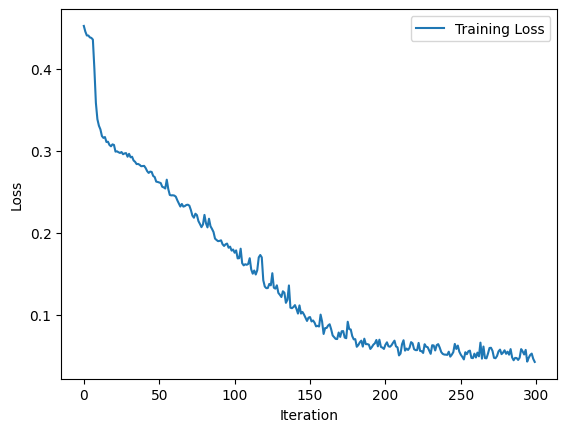

In [43]:
# Plot the loss history
plt.plot(trainingEpoch_loss, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate on test set

In [45]:
model = torch.load('/content/drive/MyDrive/CS114/best1_model.pth')
model.eval()
y_true = []
y_pred = []
progress_bar = tqdm(test_loader, colour='yellow')
with torch.no_grad():
    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)
        outputs = np.array(model(texts).tolist())
        y_pred.extend((outputs >= 0.5).astype(np.float32))
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = accuracy(y_true, y_pred)
precision = Precision(y_true, y_pred)
recall = Recall(y_true, y_pred)
F1_score = F1Measure(y_true, y_pred)

# Define the table format
table_format = "{:<12} {:<10}"

# Print the title
print("Evaluate on test set")

# Print the table header
print(table_format.format("Metric", "Value"))
print("-" * 22)  # Separating line

# Print rows with metrics
print(table_format.format("Accuracy:", f"{acc:.2%}"))
print(table_format.format("Precision:", f"{precision:.2%}"))
print(table_format.format("Recall:", f"{recall:.2%}"))
print(table_format.format("F1 Score:", f"{F1_score:.2%}"))

100%|██████████| 117/117 [00:02<00:00, 49.03it/s]

Evaluate on test set
Metric       Value     
----------------------
Accuracy:    23.75%    
Precision:   33.55%    
Recall:      30.84%    
F1 Score:    31.03%    


#Testing

In [28]:
#load model
model = torch.load('/content/drive/MyDrive/CS114/best_model.pth')
print(model)

HashtagRecommendation(
  (word_embeddings): Embedding(2180, 100)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
sentence = input()

cho mình hỏi


In [ ]:
# test = preprocessing(sentence)
test = train_set.encode_text(sentence)
test = ToTensor()(test)[None, :]
test = test.to(device)
pred = model(test)[0].tolist()
pred = [train_set.classes[i] for i in range(len(pred)) if pred[i]>0.5]
print("Predict label: ", *pred)